In [42]:
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from scipy.stats import shapiro, normaltest
import numpy as np

In [43]:
spy_full = pd.read_csv('..\Data\spy_full.csv')

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Kaizu\AppData\Local\Temp\ipykernel_58552\2302091941.py:1: SyntaxWarning: invalid escape sequence '\D'
  spy_full = pd.read_csv('..\Data\spy_full.csv')


In [44]:
spy_full.head()

,Unnamed: 0,date,adj_close,simple_return,log_return
0,0,1993-01-29,24.608631,NaN,NaN
1,1,1993-02-01,24.783640,0.007112,0.007087
2,2,1993-02-02,24.836161,0.002119,0.002117
3,3,1993-02-03,25.098705,0.010571,0.010516
4,4,1993-02-04,25.203705,0.004183,0.004175


## Step 1: Load and Preprocess Data
#### The spy_full dataset is loaded and contains columns like date (dates) and close_price (SPY prices).
#### Prophet requires columns named ds (dates) and y (target values). These are renamed accordingly.
#### Missing values in the y column are removed to ensure clean data for training.

In [45]:
# Load the `spy_full` dataset
spy_full = pd.read_csv(r'..\Data\spy_full.csv')
spy_full.rename(columns={'date': 'ds', 'adj_close': 'y'}, inplace=True)  # Rename columns for Prophet
spy_full['ds'] = pd.to_datetime(spy_full['ds'])  # Ensure datetime format
spy_full = spy_full[['ds', 'y']]  # Keep only required columns
spy_full.dropna(subset=['y'], inplace=True)  # Remove rows with missing target values

### Step 2: Train-Test Split
#### The dataset is split into 80% training data and 20% testing data based on temporal order. This preserves the time series sequence, ensuring that future data points are not leaked into the training phase.
#### Why Split?: This split allows the model to learn from historical data (training) and evaluate its performance on unseen data (testing), mimicking real-world forecasting.

In [46]:
# Train-Test Split (80% train, 20% test)
train_size = int(0.8 * len(spy_full))
train_data = spy_full.iloc[:train_size]
test_data = spy_full.iloc[train_size:]

In [47]:
model = Prophet()
model.fit(train_data)

17:03:22 - cmdstanpy - INFO - Chain [1] start processing
17:03:27 - cmdstanpy - INFO - Chain [1] done processing


### Step 3: Initialize and Fit the Prophet Model
#### A Prophet model is initialized and trained on the train_data.
#### Prophet decomposes the time series into components:
- Trend: Long-term growth/decline patterns.
- Seasonality: Recurring patterns like yearly or weekly cycles.
- Noise: Random variations not explained by the trend or seasonality.

In [48]:
cv_results = cross_validation(model, initial='1095 days', period='365 days', horizon='365 days')
cv_performance = performance_metrics(cv_results)

  0%|          | 0/22 [00:00<?, ?it/s]

17:03:27 - cmdstanpy - INFO - Chain [1] start processing
17:03:27 - cmdstanpy - INFO - Chain [1] done processing
17:03:28 - cmdstanpy - INFO - Chain [1] start processing
17:03:28 - cmdstanpy - INFO - Chain [1] done processing
17:03:28 - cmdstanpy - INFO - Chain [1] start processing
17:03:29 - cmdstanpy - INFO - Chain [1] done processing
17:03:29 - cmdstanpy - INFO - Chain [1] start processing
17:03:30 - cmdstanpy - INFO - Chain [1] done processing
17:03:30 - cmdstanpy - INFO - Chain [1] start processing
17:03:31 - cmdstanpy - INFO - Chain [1] done processing
17:03:31 - cmdstanpy - INFO - Chain [1] start processing
17:03:32 - cmdstanpy - INFO - Chain [1] done processing
17:03:32 - cmdstanpy - INFO - Chain [1] start processing
17:03:32 - cmdstanpy - INFO - Chain [1] done processing
17:03:33 - cmdstanpy - INFO - Chain [1] start processing
17:03:33 - cmdstanpy - INFO - Chain [1] done processing
17:03:34 - cmdstanpy - INFO - Chain [1] start processing
17:03:34 - cmdstanpy - INFO - Chain [1]

### Step 4: Cross-Validation
#### What is Cross-Validation?
- It involves splitting the training data into smaller segments to simulate multiple training and testing phases.
- The Prophet cross_validation function evaluates the model's performance on a rolling horizon. For example:
- Train on data up to t1 and test on t1+1.
- Expand the training set to include t1+1 and test on t1+2, and so on.
#### Purpose:
- To measure how well the model generalizes to unseen data within the training period.
- To tune the model if necessary (e.g., adjust seasonality, trend change point prior).
#### Output Metrics:
- RMSE (Root Mean Squared Error): Measures the average error magnitude, emphasizing larger errors.
- MAE (Mean Absolute Error): Measures the average absolute error, providing a more balanced error view.
- MAPE (Mean Absolute Percentage Error): Indicates error as a percentage of actual values.
- Coverage: Measures the percentage of actual values falling within the model's prediction intervals.

In [49]:
print("Cross-Validation Metrics (Summary):")
print(cv_performance[['mse', 'horizon', 'coverage']].head())
print(cv_performance[['mse', 'horizon', 'coverage']].tail())

Cross-Validation Metrics (Summary):
         mse horizon  coverage
0  49.773401 36 days  0.524638
1  49.948500 37 days  0.527667
2  50.030366 38 days  0.524171
3  49.606654 39 days  0.526673
4  49.285946 40 days  0.531759
            mse  horizon  coverage
325  387.370778 361 days  0.250271
326  388.399133 362 days  0.250000
327  393.179198 363 days  0.247401
328  398.780058 364 days  0.242767
329  401.744194 365 days  0.239941


### What Happens During Prophet's Cross-Validation (CV)?
#### When you use Prophet’s cross_validation() function after fitting the model, the CV process creates training and validation splits from the already fitted dataset to evaluate how well the model performs on unseen data.

#### Here’s how Prophet’s CV works:

- Cuts the Data into Folds:

    - The training data is divided into multiple folds based on the initial, period, and horizon parameters.
    - For each fold:
        - A subset of the training data (up to a specified cutoff point) is used as the training set.
        - The next horizon period is used as the validation set (unseen data for that fold).

#### Retrains the Model on Each Training Fold:

- For each fold, Prophet refits the model using only the training subset for that fold.
- The validation data for that fold is not seen during the training process for that fold.

#### Generates Predictions for the Validation Set:

- The model makes predictions for the validation set (future horizon) based on the subset of training data it was fitted on.

#### Evaluates Performance:

- Performance metrics (e.g., RMSE, MAPE) are calculated by comparing predictions against the actual values in the validation set.
#### This process ensures that the model’s performance is tested on unseen data, making the evaluation more reliable.



#### Why Use Prophet CV After Fitting the Model?
##### Even though model.fit() uses all the training data, Prophet's CV re-fits the model for each fold using only part of the data. This process simulates how the model would perform in a real-world scenario where it only has access to historical data up to a certain point and needs to forecast future values.



In [50]:
# Calculate the Exact Number of Days to Forecast
last_date = spy_full['ds'].max()  # Get the last date in the dataset
target_end_date = datetime(2044, 12, 31)  # Define the desired end date
days_to_forecast = (target_end_date - last_date).days  # Calculate days to forecast

### Step 5: Forecast 20 Years Into the Future
#### The model predicts prices for these future dates, providing:
- yhat: Central forecast (predicted price).
- yhat_lower, yhat_upper: Prediction intervals (uncertainty bounds).

In [51]:
# Fitting full dataset on new model
model_full = Prophet()
model_full.fit(spy_full)

17:04:09 - cmdstanpy - INFO - Chain [1] start processing
17:04:13 - cmdstanpy - INFO - Chain [1] done processing


In [52]:
# Forecast 20 years into the future
future_full = model_full.make_future_dataframe(periods=365 * 20)
forecast_full = model_full.predict(future_full)

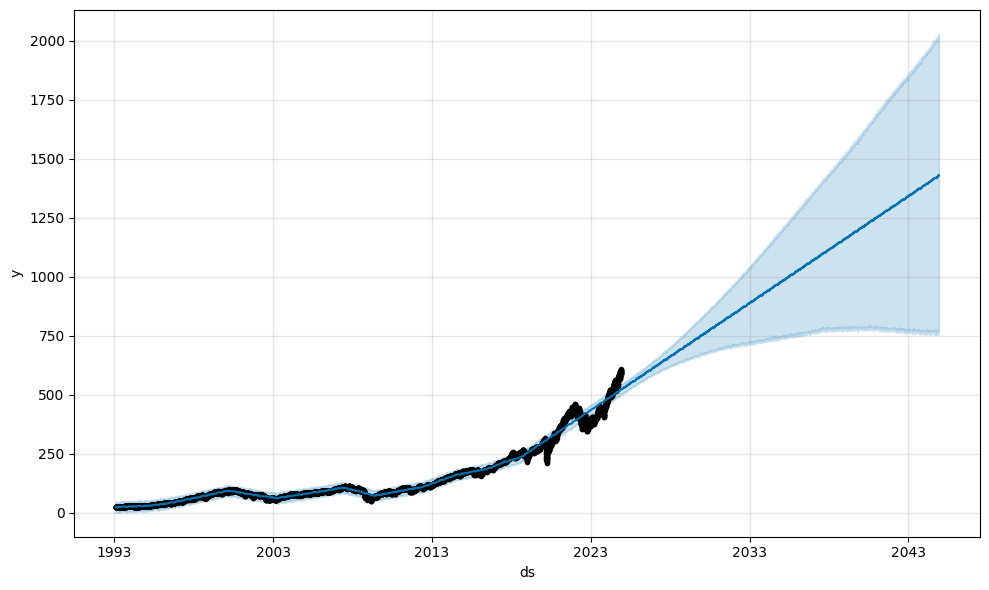

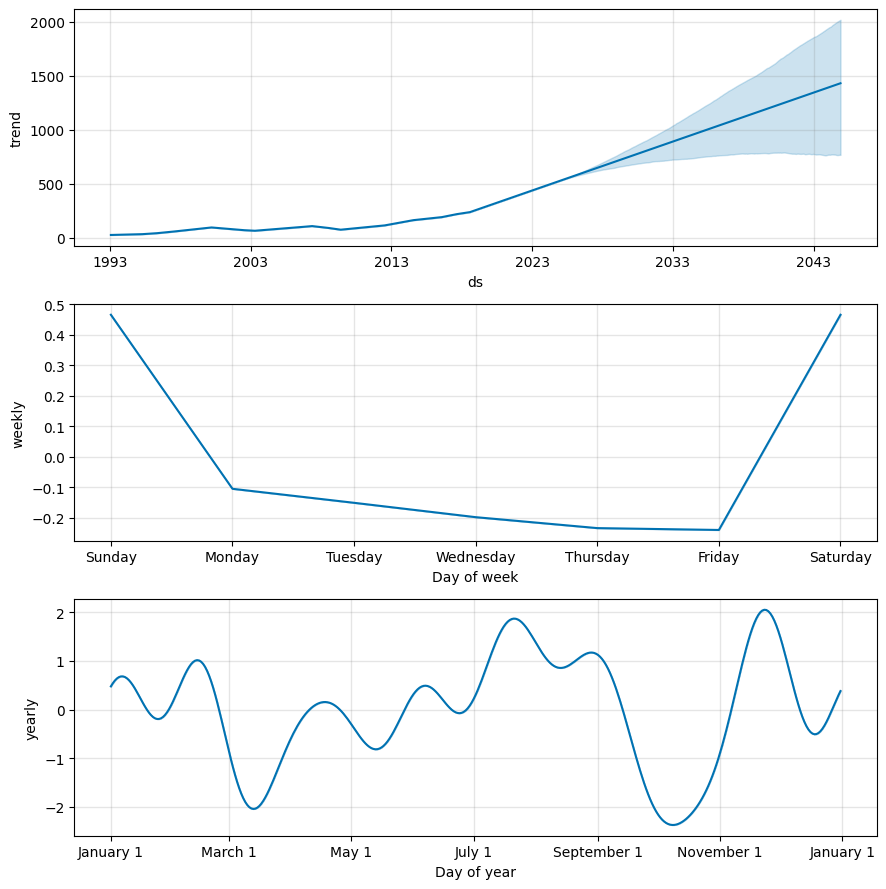

              ds         yhat  yhat_lower   yhat_upper
15315 2044-11-25  1429.648352  766.195273  2022.041127
15316 2044-11-26  1430.427694  766.985132  2017.796252
15317 2044-11-27  1430.481839  765.760388  2020.966955
15318 2044-11-28  1429.946874  764.982537  2022.166532
15319 2044-11-29  1429.920101  771.664118  2029.256425


In [53]:
# Visualize forecasts
model_full.plot(forecast_full)
model_full.plot_components(forecast_full)
plt.show()

# Print forecasted values
print(forecast_full[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

In [59]:
# Filter forecasted data for dates after December 2024
forecast_full_filtered = forecast_full[forecast_full['ds'] > '2024-12-31']

# Rename and select only required columns
forecast_full_renamed = forecast_full_filtered[['ds', 'yhat']].rename(columns={'ds': 'date', 'yhat': 'forecast'})

# Save the renamed and filtered dataframe
forecast_full_renamed.to_csv('forecasted_prices_post_2024.csv', index=False)

# Display the last few rows of the modified dataframe
print("\nSample of Forecasted Prices (Post-December 2024):")
print(forecast_full_renamed.tail())



Sample of Forecasted Prices (Post-December 2024):
            date     forecast
15315 2044-11-25  1429.648352
15316 2044-11-26  1430.427694
15317 2044-11-27  1430.481839
15318 2044-11-28  1429.946874
15319 2044-11-29  1429.920101


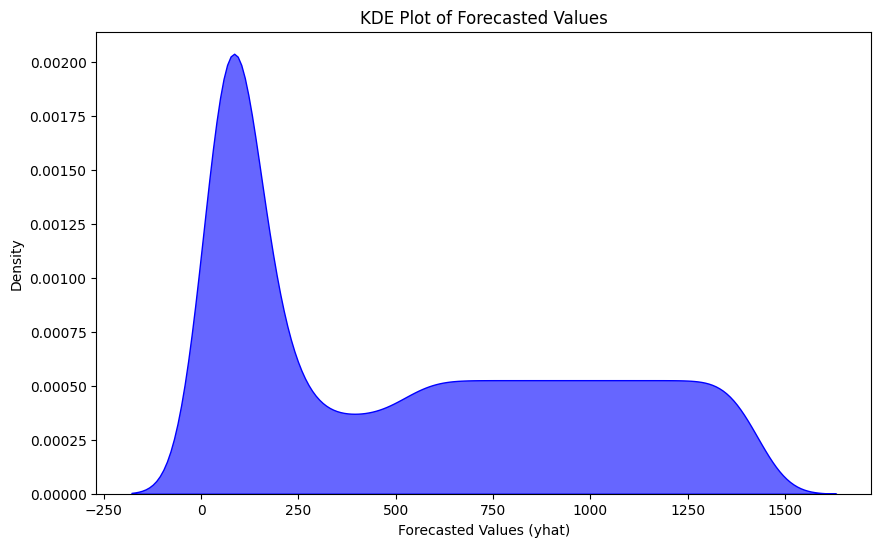

Shapiro-Wilk Test:
  Statistic: 0.8757634071491576, p-value: 9.61156374321484e-76

Kolmogorov-Smirnov Test (D’Agostino and Pearson):
  Statistic: 53190.680370874725, p-value: 0.0

The predictions do not appear to be normally distributed (reject null hypothesis).


c:\Users\Kaizu\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 15320.
  res = hypotest_fun_out(*samples, **kwds)


In [54]:
# Extract predictions (yhat) or residuals
forecast_values = forecast_full['yhat']  # Use 'yhat' for forecasted values
# residuals = spy_full['y'] - forecast_full['yhat'][:len(spy_full)]  # Uncomment for residuals

# Plot KDE for Forecasted Values
plt.figure(figsize=(10, 6))
sns.kdeplot(forecast_values, fill=True, color='blue', alpha=0.6)
plt.title('KDE Plot of Forecasted Values')
plt.xlabel('Forecasted Values (yhat)')
plt.ylabel('Density')
plt.show()

# Perform Statistical Normality Tests
shapiro_test = shapiro(forecast_values)
kstest = normaltest(forecast_values)

# Print results
print("Shapiro-Wilk Test:")
print(f"  Statistic: {shapiro_test.statistic}, p-value: {shapiro_test.pvalue}")

print("\nKolmogorov-Smirnov Test (D’Agostino and Pearson):")
print(f"  Statistic: {kstest.statistic}, p-value: {kstest.pvalue}")

# Interpretation
if shapiro_test.pvalue > 0.05 and kstest.pvalue > 0.05:
    print("\nThe predictions appear to be normally distributed (fail to reject null hypothesis).")
else:
    print("\nThe predictions do not appear to be normally distributed (reject null hypothesis).")

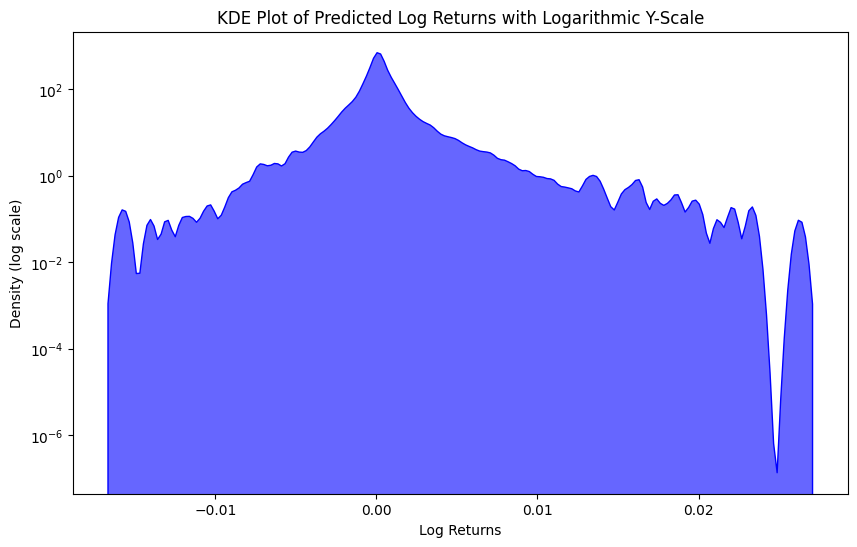

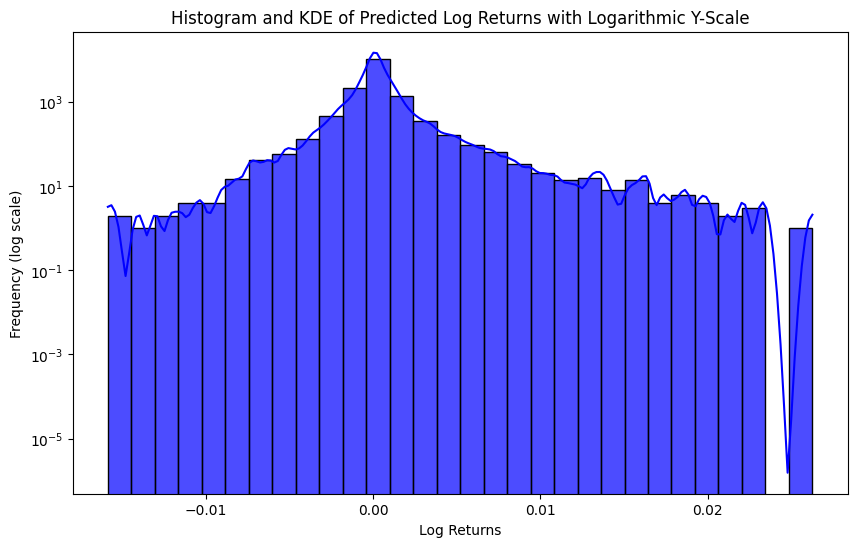

In [55]:
# Extract predicted prices (yhat)
predicted_prices = forecast_full['yhat']

# Compute log returns
predicted_log_returns = np.log(predicted_prices / predicted_prices.shift(1))

# Drop NaN values from the first computation
predicted_log_returns.dropna(inplace=True)

# Visualize KDE with a logarithmic y-scale
plt.figure(figsize=(10, 6))
sns.kdeplot(predicted_log_returns, fill=True, color='blue', alpha=0.6)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title('KDE Plot of Predicted Log Returns with Logarithmic Y-Scale')
plt.xlabel('Log Returns')
plt.ylabel('Density (log scale)')
plt.show()

# Visualize Histogram + KDE with a logarithmic y-scale
plt.figure(figsize=(10, 6))
sns.histplot(predicted_log_returns, kde=True, bins=30, color='blue', alpha=0.7)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title('Histogram and KDE of Predicted Log Returns with Logarithmic Y-Scale')
plt.xlabel('Log Returns')
plt.ylabel('Frequency (log scale)')
plt.show()

# Understanding Prophet's Cross-Validation Parameters
1. initial
- Defines the initial training period, i.e., how much historical data to use for training in the first fold.
- It specifies how far back in time the training data starts relative to the earliest validation period.
- For example:
If initial='1095 days', the model is trained on the first 3 years of data before starting validation.

2. horizon
- Defines the forecast horizon, i.e., how far into the future the model is evaluated for predictions.
- Determines the length of the validation period.
- For example:
If horizon='365 days', the model's predictions are compared against the actual values 1 year (365 days) into the future.

3. period
- Defines the gap between successive validation cutoffs.
- It controls how often the training window is moved forward for the next validation.
- For example:
If period='365 days', the validation is performed every 1 year.

# How Cross-Validation Works in Prophet
## Prophet uses rolling origin cross-validation, which evaluates the model on successive validation sets as the training window shifts forward.

### Here’s a step-by-step example:

#### Setup
- Dataset: Historical data with daily frequency.
- Parameters:
    1. initial='1095 days': Use the first 3 years for training.
    2. horizon='365 days': Evaluate 1-year forecasts.
    3. period='365 days': Shift the training window by 1 year for each fold.